# Twitter runs for 'Discovering Foodborne Illness in Online Restaurant Reviews'

This notebook presents the evaluation of twitter classifiers presented in the paper.

## Table of Contents


1. [Setup](#)
    1. [Data Ingestion](#) (Data is cleaned ahead of time)
    4. [Loading Models](#) (Model hyperparams are pre-tuned)
2. [Sick Task](#)
    1. [Logistic Regression](#)
    2. [Random Forest](#)
    3. [SVM](#)
    4. [Prototype](#)
3. [Multiple Task](#)
    1. [Logistic Regression](#)
    2. [Random Forest](#)
    3. [SVM](#)
    4. [Pipelined Logistic Regression](#)
    5. [Prototype](#)

# Setup

In [1]:
import time
%matplotlib inline
from copy import deepcopy
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter('ignore')
from __future__ import print_function
import logging
logging.basicConfig(level=logging.DEBUG)

In [2]:
from experiments.baseline_experiment_util import setup_baseline_data, calc_importance_weights
from experiments.baseline_experiment_util import model_report, pr_curves, print_model_hyperparams

In [3]:
random_seed = 0

## Data Ingestion

In [4]:
biased_data = setup_baseline_data(dataset='twitter', data_path='./data/twitter_data/',
                                  train_regime='biased', test_regime='biased', random_seed=random_seed)
silver_data = setup_baseline_data(dataset='twitter', data_path='./data/twitter_data/',
                                  train_regime='silver', test_regime='silver', random_seed=random_seed)
gold_data = setup_baseline_data(dataset='twitter', data_path='./data/twitter_data/',
                                  train_regime='gold', test_regime='gold', random_seed=random_seed)

INFO:experiments.baseline_experiment_util:data setup with len(train_data.text) = 7244 len(test_data.text) = 1893 all_B_over_U = 0.00173566547282
INFO:experiments.baseline_experiment_util:data setup with len(train_data.text) = 8244 len(test_data.text) = 2893 all_B_over_U = 0.00173566547282
INFO:experiments.baseline_experiment_util:data setup with len(train_data.text) = 8129 len(test_data.text) = 2822 all_B_over_U = 0.00173566547282


In [5]:
# train setup
biased_text = np.array(biased_data['train_data']['text'])
biased_sick = np.array(biased_data['train_data']['is_foodborne'])
biased_weights = calc_importance_weights(biased_data['train_data']['is_biased'], biased_data['all_B_over_U'])

gold_text = np.array(gold_data['train_data']['text'])
gold_sick = np.array(gold_data['train_data']['is_foodborne'])
gold_weights = calc_importance_weights(gold_data['train_data']['is_biased'], gold_data['all_B_over_U'])

silver_text = np.array(silver_data['train_data']['text'])
silver_sick = np.array(silver_data['train_data']['is_foodborne'])
silver_weights = calc_importance_weights(silver_data['train_data']['is_biased'], silver_data['all_B_over_U'])

# test setup
test_data = gold_data['test_data']
B = 1000 # number of bootstrap test set resamples
all_results = {}

## Loading Models

In [6]:
from experiments.lr_model import model as lr_model
from experiments.rf_model import model as rf_model
from experiments.svm_model import model as svm_model
from sklearn.externals import joblib

In [7]:
# logistic regression sick models
best_sick_lr_biased = joblib.load('data/best_models_twitter/best_lr_sick_biased.pkl')
best_sick_lr_silver = joblib.load('data/best_models_twitter/best_lr_sick_silver.pkl')
best_sick_lr_gold = joblib.load('data/best_models_twitter/best_lr_sick_gold.pkl')

In [8]:
# random forest sick models
best_sick_rf_biased = joblib.load('data/best_models_twitter/best_rf_sick_biased.pkl')
best_sick_rf_silver = joblib.load('data/best_models_twitter/best_rf_sick_silver.pkl')
best_sick_rf_gold = joblib.load('data/best_models_twitter/best_rf_sick_gold.pkl')

In [9]:
# svm sick models
best_sick_svm_biased = joblib.load('data/best_models_twitter/best_svm_sick_biased.pkl')
best_sick_svm_silver = joblib.load('data/best_models_twitter/best_svm_sick_silver.pkl')
best_sick_svm_gold = joblib.load('data/best_models_twitter/best_svm_sick_gold.pkl')

## Sick Task

Here are the notable stats for testing on the Sick task:
### TODO!!!
* All the test data is from 1/1/2017 and later
* It's about 2/3 biased and 1/3 nonbiased (1975 and 1000 reviews, respectively)
* All 1000 nonbiased reviews are have `No` labels
* The 1975 biased reviews are about 52% `Yes`/`No` (1026/949)

### Sick: Logistic Regression

In [10]:
best_sick_lr_biased.fit(biased_text, biased_sick, logreg__sample_weight=biased_weights)
best_sick_lr_gold.fit(gold_text, gold_sick, logreg__sample_weight=gold_weights)
best_sick_lr_silver.fit(silver_text, silver_sick, logreg__sample_weight=silver_weights)
print()


B: 999/1000
B: 999/1000
B: 999/1000
3 seconds for evaluation



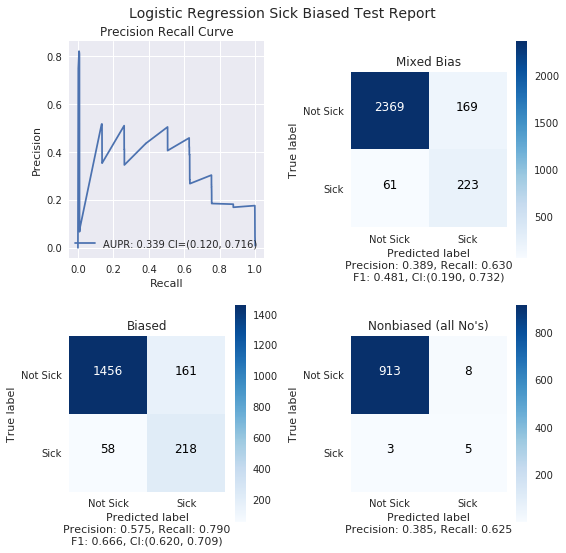

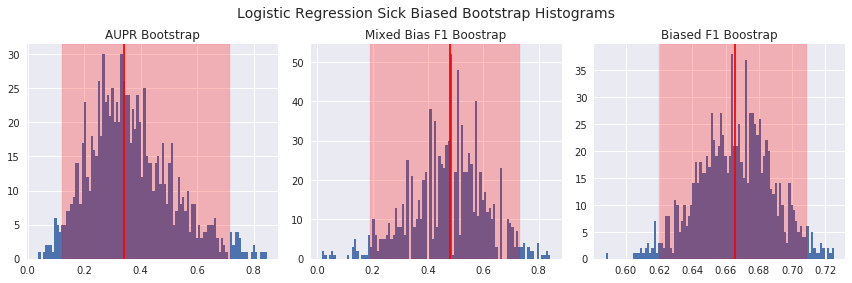

In [11]:
start = time.time()
title = 'Logistic Regression Sick Biased'
all_results[title] = model_report(best_sick_lr_biased, title, 'is_foodborne',
                                  test_data=test_data,
                                  save_fname='figures/sick_lr_biased',
                                  B=B, random_seed=random_seed)
print('\n{} seconds for evaluation'.format(int(time.time()-start)))


B: 999/1000
B: 999/1000
B: 999/1000
3 seconds



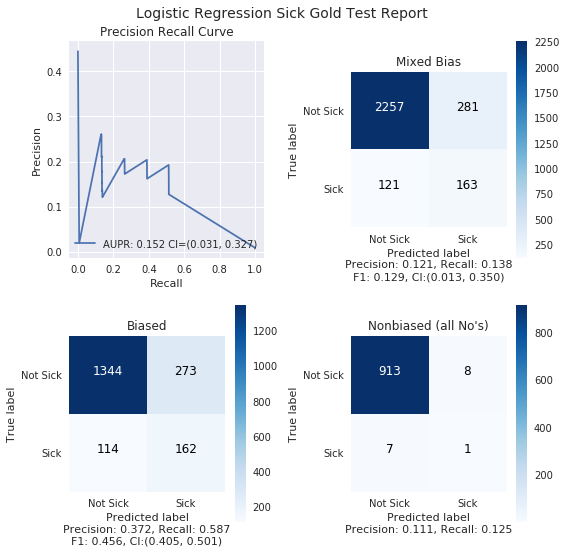

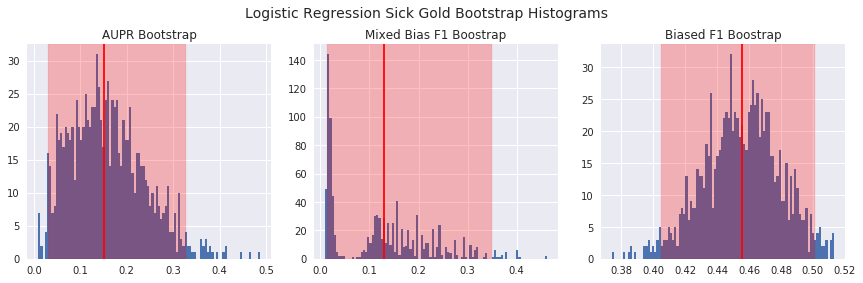

In [12]:
start = time.time()
title = 'Logistic Regression Sick Gold'
all_results[title] = model_report(best_sick_lr_gold, title, 'is_foodborne', 
                                  test_data=test_data,
                                   save_fname='figures/sick_lr_gold',
                                   B=B, random_seed=random_seed)
print('\n{} seconds'.format(int(time.time()-start)))


B: 999/1000
B: 999/1000
B: 999/1000
3 seconds



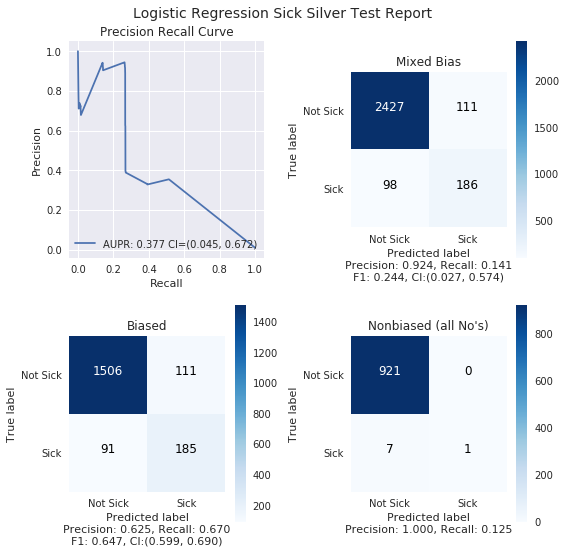

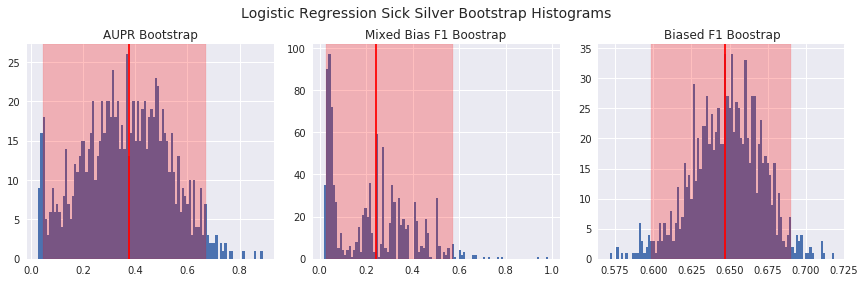

In [13]:
start = time.time()
title = 'Logistic Regression Sick Silver'
all_results[title] = model_report(best_sick_lr_silver, title, 'is_foodborne', 
                                  test_data=test_data,
                                  save_fname='figures/sick_lr_silver',
                                  B=B, random_seed=random_seed)
print('\n{} seconds'.format(int(time.time()-start)))

### Precision Recall Tradeoffs

We'd like to explore how we lose precision with the LR models, as we gain recall. This can be visualized by looking at the high recall region of the PR curves. 

In the curve we can see that all of the model precision begins to drop around a recall of .8 start to significantly drop precision around a recall of .9

(<matplotlib.figure.Figure at 0x7f307e187cd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f30878c1f90>)

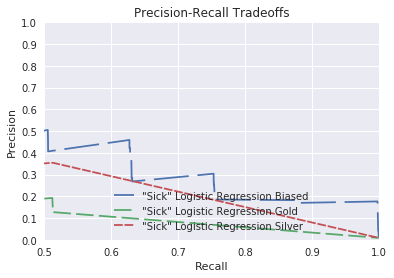

In [14]:
pr_curves([best_sick_lr_biased, best_sick_lr_gold, best_sick_lr_silver], 
          ['"Sick" Logistic Regression Biased', 
           '"Sick" Logistic Regression Gold', 
           '"Sick" Logistic Regression Silver'], 
          'Precision-Recall Tradeoffs', 'is_foodborne', 
          dashes=[[20,5], [10,3], [5,1]],
          test_data=test_data, save_fname='figures/paper_sick_lr',
          figsize=(6,4),
          xlim=(.5,1.),
          yticks=.1*np.arange(11))

In [15]:
print_model_hyperparams(best_sick_lr_biased, 'Logistic Regression Sick Biased')
print()
print_model_hyperparams(best_sick_lr_gold, 'Logistic Regression Sick Gold')
print()
print_model_hyperparams(best_sick_lr_silver, 'Logistic Regression Sick Silver')
print()

*** Logistic Regression Sick Biased Hyperparameters ***
{'count__analyzer': u'word',
 'count__binary': False,
 'count__decode_error': u'strict',
 'count__dtype': <type 'numpy.int64'>,
 'count__encoding': u'utf-8',
 'count__input': u'content',
 'count__lowercase': True,
 'count__max_df': 0.82803225160121241,
 'count__max_features': None,
 'count__min_df': 1,
 'count__ngram_range': (1, 2),
 'count__preprocessor': None,
 'count__stop_words': None,
 'count__strip_accents': None,
 'count__token_pattern': u'(?u)\\b\\w\\w+\\b',
 'count__tokenizer': None,
 'count__vocabulary': None,
 'logreg__C': 8733.6165326127684,
 'logreg__class_weight': None,
 'logreg__dual': False,
 'logreg__fit_intercept': True,
 'logreg__intercept_scaling': 1,
 'logreg__max_iter': 100,
 'logreg__multi_class': 'ovr',
 'logreg__n_jobs': 1,
 'logreg__penalty': 'l2',
 'logreg__random_state': None,
 'logreg__solver': 'liblinear',
 'logreg__tol': 0.0001,
 'logreg__verbose': 0,
 'logreg__warm_start': False,
 'tfidf__norm': 'l2

### Sick: Random Forest

In [16]:
best_sick_rf_biased.fit(biased_text, biased_sick, rf__sample_weight=biased_weights)
best_sick_rf_gold.fit(gold_text, gold_sick, rf__sample_weight=gold_weights)
best_sick_rf_silver.fit(silver_text, silver_sick, rf__sample_weight=silver_weights)
print()


B: 999/1000
B: 999/1000
B: 999/1000
3 seconds



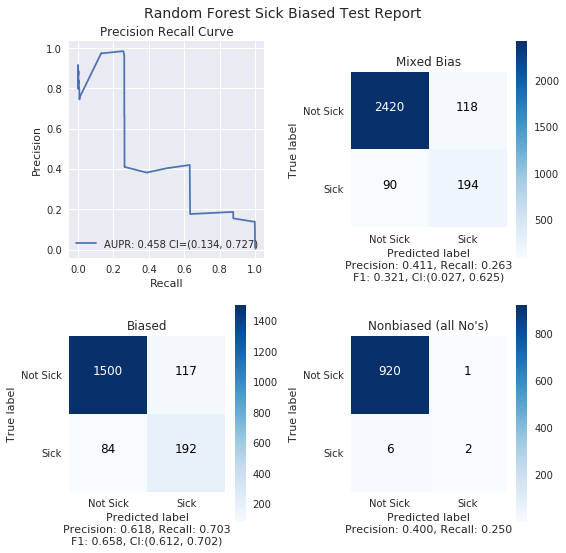

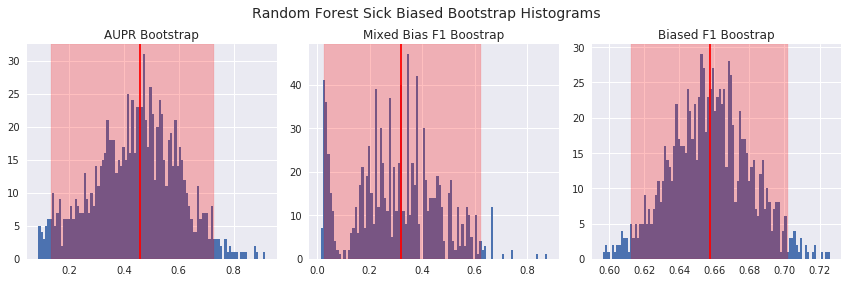

In [17]:
start = time.time()
title = 'Random Forest Sick Biased'
all_results[title] = model_report(best_sick_rf_biased, title, 'is_foodborne',
                                  save_fname='figures/sick_rf_biased',
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)
print('\n{} seconds'.format(int(time.time()-start)))


B: 999/1000
B: 999/1000
B: 999/1000
3 seconds



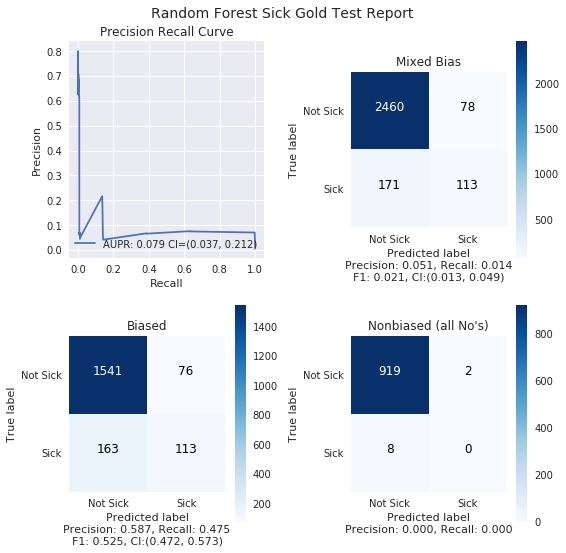

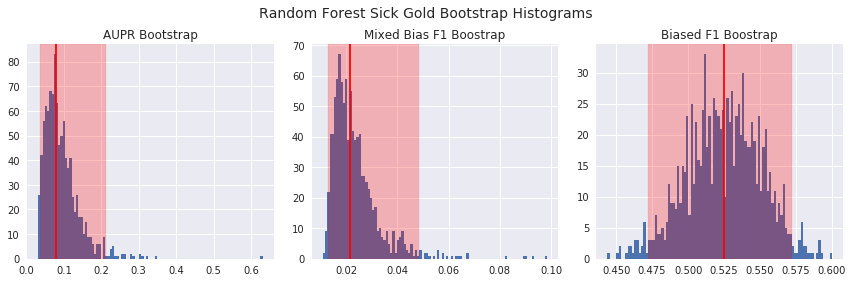

In [18]:
start = time.time()
title = 'Random Forest Sick Gold'
all_results[title] = model_report(best_sick_rf_gold, title, 'is_foodborne',
                                  save_fname='figures/sick_rf_gold',
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)
print('\n{} seconds'.format(int(time.time()-start)))


B: 999/1000
B: 999/1000
B: 999/1000
3 seconds



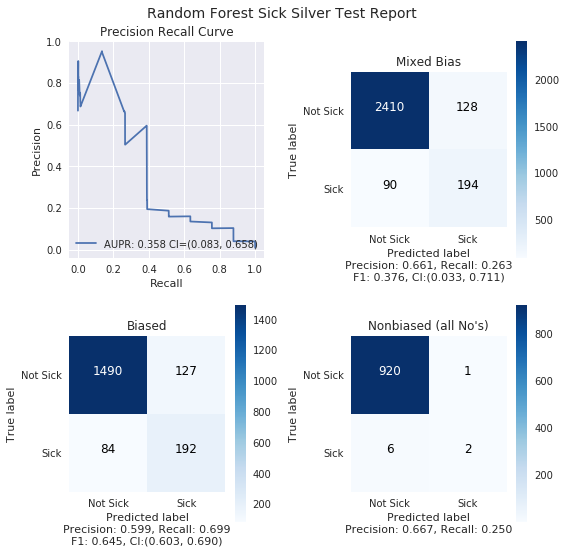

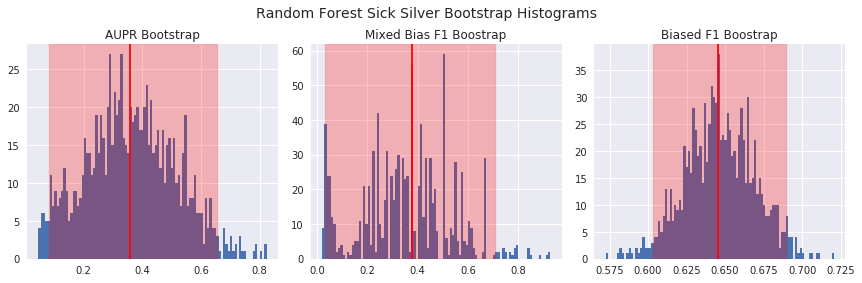

In [19]:
start = time.time()
title = 'Random Forest Sick Silver'
all_results[title] = model_report(best_sick_rf_silver, title, 'is_foodborne',
                                  save_fname='figures/sick_rf_silver',
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)
print('\n{} seconds'.format(int(time.time()-start)))

In [20]:
print_model_hyperparams(best_sick_rf_biased, 'Random Forest Sick Biased')
print()
print_model_hyperparams(best_sick_rf_gold, 'Random Forest Sick Gold')
print()
print_model_hyperparams(best_sick_rf_silver, 'Random Forest Sick Silver')
print()

*** Random Forest Sick Biased Hyperparameters ***
{'count__analyzer': u'word',
 'count__binary': False,
 'count__decode_error': u'strict',
 'count__dtype': <type 'numpy.int64'>,
 'count__encoding': u'utf-8',
 'count__input': u'content',
 'count__lowercase': True,
 'count__max_df': 0.91013730004810611,
 'count__max_features': 1000,
 'count__min_df': 1,
 'count__ngram_range': (1, 2),
 'count__preprocessor': None,
 'count__stop_words': None,
 'count__strip_accents': None,
 'count__token_pattern': u'(?u)\\b\\w\\w+\\b',
 'count__tokenizer': None,
 'count__vocabulary': None,
 'rf__bootstrap': True,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__max_leaf_nodes': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_impurity_split': None,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 106,
 'rf__n_jobs': 1,
 'rf__oob_score': True,
 'rf__random_state': 0,
 'rf__verb

### Sick: SVM

In [21]:
best_sick_svm_biased.fit(biased_text, biased_sick, svc__sample_weight=biased_weights)
best_sick_svm_gold.fit(gold_text, gold_sick, svc__sample_weight=gold_weights)
best_sick_svm_silver.fit(silver_text, silver_sick, svc__sample_weight=silver_weights)
print()


B: 999/1000
B: 999/1000
B: 999/1000
3 seconds



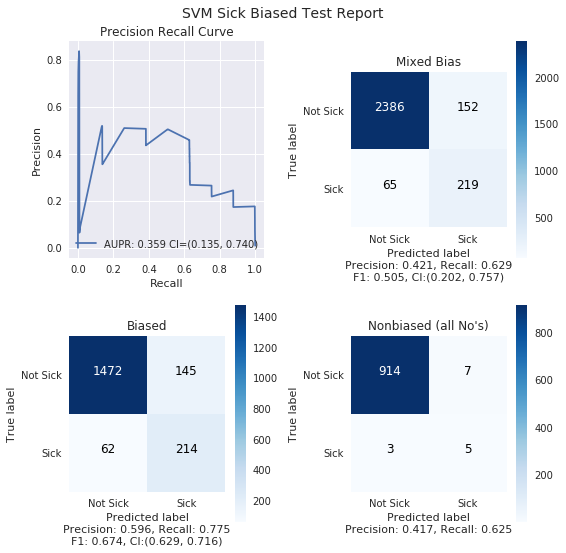

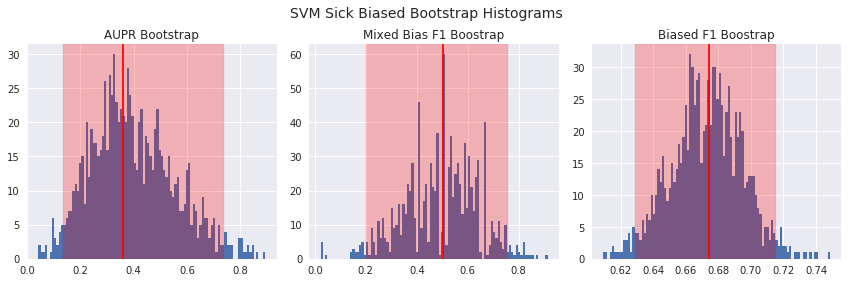

In [22]:
start = time.time()
title = 'SVM Sick Biased'
all_results[title] = model_report(best_sick_svm_biased, title, 'is_foodborne',
                                  save_fname='figures/sick_svm_biased',
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)
print('\n{} seconds'.format(int(time.time()-start)))


B: 999/1000
B: 999/1000
B: 999/1000
3 seconds



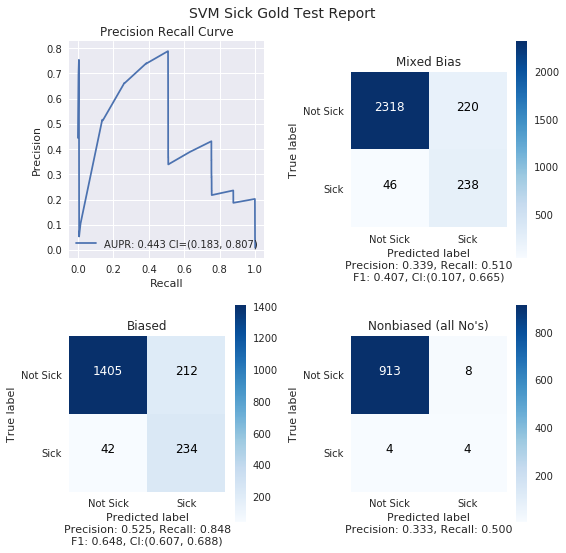

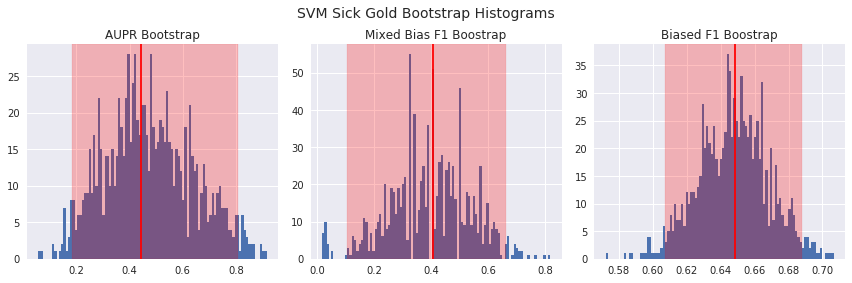

In [23]:
start = time.time()
title = 'SVM Sick Gold'
all_results[title] = model_report(best_sick_svm_gold, title, 'is_foodborne',
                                  save_fname='figures/sick_svm_gold',
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)
print('\n{} seconds'.format(int(time.time()-start)))


B: 999/1000
B: 999/1000
B: 999/1000
3 seconds



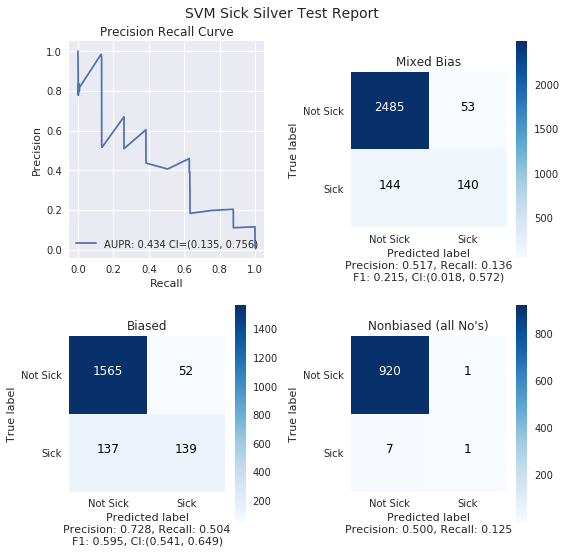

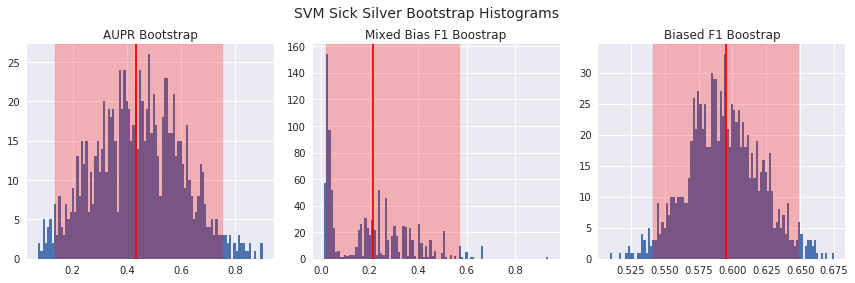

In [24]:
start = time.time()
title = 'SVM Sick Silver'
all_results[title] = model_report(best_sick_svm_silver, title, 'is_foodborne',
                                  save_fname='figures/sick_svm_silver',
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)
print('\n{} seconds'.format(int(time.time()-start)))

In [25]:
print_model_hyperparams(best_sick_svm_biased, 'SVM Sick Biased')
print()
print_model_hyperparams(best_sick_svm_gold, 'SVM Sick Gold')
print()
print_model_hyperparams(best_sick_svm_silver, 'SVM Sick Silver')
print()

*** SVM Sick Biased Hyperparameters ***
{'count__analyzer': u'word',
 'count__binary': False,
 'count__decode_error': u'strict',
 'count__dtype': <type 'numpy.int64'>,
 'count__encoding': u'utf-8',
 'count__input': u'content',
 'count__lowercase': True,
 'count__max_df': 0.8801897410065691,
 'count__max_features': None,
 'count__min_df': 1,
 'count__ngram_range': (1, 2),
 'count__preprocessor': None,
 'count__stop_words': None,
 'count__strip_accents': None,
 'count__token_pattern': u'(?u)\\b\\w\\w+\\b',
 'count__tokenizer': None,
 'count__vocabulary': None,
 'svc__base_estimator': LinearSVC(C=1.0974987654930557, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0),
 'svc__base_estimator__C': 1.0974987654930557,
 'svc__base_estimator__class_weight': None,
 'svc__base_estimator__dual': True,
 'svc__base_estimator__fit_intercept': True,
 'svc__b

## Compile the scores into a nice table

In [26]:
sick_table = pd.DataFrame()
# mult_table = pd.DataFrame()
for name, result in sorted(all_results.items(), key=lambda x:x[0]):
    data = {k:v for k,v in result.items() if ('samples' not in k) and ('_ci' not in k) }
    data.update({k+'_b':v[0] for k,v in result.items() if '_ci' in k})
    data.update({k+'_t':v[1] for k,v in result.items() if '_ci' in k})
    data['name'] = name
    if 'Sick' in name and 'Sick Only' not in name:
        sick_table = sick_table.append(data, ignore_index=True)
    else:
        pass
        # mult_table = mult_table.append(data, ignore_index=True)
sick_table.set_index('name', inplace=True)
# mult_table.set_index('name', inplace=True)

In [27]:
print(sick_table.columns)

Index([u'aupr', u'aupr_ci_b', u'aupr_ci_t', u'biased_f1', u'biased_f1_ci_b',
       u'biased_f1_ci_t', u'biased_precision', u'biased_recall', u'mixed_f1',
       u'mixed_f1_ci_b', u'mixed_f1_ci_t', u'mixed_precision',
       u'mixed_recall'],
      dtype='object')


In [28]:
sick_table.to_csv('sick_results.csv')
sick_table[['mixed_f1', 'mixed_f1_ci_b', 'mixed_f1_ci_t']]

,mixed_f1,mixed_f1_ci_b,mixed_f1_ci_t
name,,,
Logistic Regression Sick Biased,0.481102,0.189691,0.731964
Logistic Regression Sick Gold,0.129295,0.012793,0.350008
Logistic Regression Sick Silver,0.244065,0.027319,0.573528
Random Forest Sick Biased,0.320738,0.027001,0.624907
Random Forest Sick Gold,0.021443,0.013061,0.048572
Random Forest Sick Silver,0.376131,0.033229,0.711466
SVM Sick Biased,0.504590,0.201991,0.757270
SVM Sick Gold,0.407417,0.106969,0.664577
SVM Sick Silver,0.215148,0.018472,0.572127


In [29]:
sick_table

,aupr,aupr_ci_b,aupr_ci_t,biased_f1,biased_f1_ci_b,biased_f1_ci_t,biased_precision,biased_recall,mixed_f1,mixed_f1_ci_b,mixed_f1_ci_t,mixed_precision,mixed_recall
name,,,,,,,,,,,,,
Logistic Regression Sick Biased,0.339350,0.119617,0.716443,0.665649,0.619900,0.708825,0.575198,0.789855,0.481102,0.189691,0.731964,0.389241,0.629714
Logistic Regression Sick Gold,0.151504,0.031377,0.327446,0.455696,0.404936,0.501363,0.372414,0.586957,0.129295,0.012793,0.350008,0.121461,0.138210
Logistic Regression Sick Silver,0.377347,0.045332,0.672110,0.646853,0.598794,0.690148,0.625000,0.670290,0.244065,0.027319,0.573528,0.924385,0.140593
Random Forest Sick Biased,0.458307,0.134371,0.727297,0.657627,0.612464,0.702104,0.617834,0.702899,0.320738,0.027001,0.624907,0.411079,0.262951
Random Forest Sick Gold,0.079456,0.036668,0.212169,0.525050,0.472008,0.572578,0.587444,0.474638,0.021443,0.013061,0.048572,0.051034,0.013573
Random Forest Sick Silver,0.358148,0.082809,0.658429,0.645485,0.603159,0.690240,0.599379,0.699275,0.376131,0.033229,0.711466,0.661021,0.262847
SVM Sick Biased,0.358629,0.134869,0.740363,0.674016,0.628859,0.715545,0.596100,0.775362,0.504590,0.201991,0.757270,0.421133,0.629300
SVM Sick Gold,0.442649,0.182727,0.807342,0.648199,0.607046,0.687989,0.524664,0.847826,0.407417,0.106969,0.664577,0.339215,0.509946
SVM Sick Silver,0.434109,0.134985,0.755540,0.595289,0.541283,0.649087,0.727749,0.503623,0.215148,0.018472,0.572127,0.517160,0.135827


In [30]:
# mult_table.to_csv('mult_results.csv')
# mult_table[['mixed_f1', 'mixed_f1_ci_b', 'mixed_f1_ci_t']]

### Write out the final Sick and Multiple classifiers -- Sick LR Silver and Mult LR Pipelined Silver

In [31]:
# joblib.dump(best_sick_lr_silver, 'final_models/final_yelp_sick_model.gz')
# joblib.dump(sick_only_mult_lr_silver, 'final_models/final_yelp_mult_model.gz')